# Trabajo final LC POS-Tagging. Curso 2020-2021
### Jaime Ferrando Huertas
### Javier Martínez Bernia

## Preparamos los datos

In [1]:
#IMPORTS
import nltk
from nltk.corpus import cess_esp
from nltk.tag import UnigramTagger,BigramTagger,hmm, tnt, AffixTagger,brill, brill_trainer, crf, perceptron
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from random import shuffle

nltk.download('cess_esp')

[nltk_data] Downloading package cess_esp to /home/javi/nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!


True

In [2]:
#Cargamos el corpus

corpus = list(cess_esp.tagged_sents())
number_sentences = len(corpus)
print("number of sentnces:", number_sentences)
print("number of words:", number_sentences)


number of sentnces: 6030
number of words: 6030


In [3]:
#Procesamos el corpus
processed_corpus = []
for sentence in corpus:
    tmp_sentence = []
    for word in sentence:
        if word[0] == "*0*":
            continue
        if word[1][0] == "v" or "F":
            new_word = (word[0], word[1][:3])
        else:
            new_word = (palabra_etiquetada[0], word[1][:2])
        tmp_sentence.append(new_word)
    processed_corpus.append(tmp_sentence)

In [4]:
# Escribir el corpus en un fichero
outfile = open('corpus.txt', 'w') 
for s in (corpus):
    str=''
    for x in s:
        str=str+('¬'.join(x)+' ')  # Si usamos el caracter '/' tiene problemas
    #print (str)    
    outfile.write(str+'\n')
outfile.close()

In [5]:
#leer el corpus de un fichero y guardalo en una lista
infile = open('corpus.txt', 'r')
corpus=[]
for line in infile:
    corpus.append(line.strip('\n'))
infile.close()
#print (corpus[5667])

In [6]:
# Procesamos el corpus (leído del fichero de texto)
processed_corpus = []
for s in corpus:
    new_s = []
    for w_c in s.split():
        w,cat = w_c.split('¬')
        
        if (w !='*0*'):
            if (cat[0] == 'F' or cat[0] == 'v'):
                new_cat = cat[0:3]
            else:
                new_cat = cat[0:2]                
            new_s.append((w,new_cat))

    processed_corpus.append(new_s)

In [4]:
# Shuffle data
shuffle(corpus)
shuffle(processed_corpus)

# Tarea 1 

En esta tarea realizaremos una evaluación del etiquetador 'hmm' sobre el corpus 'cess-esp' mediante validación cruzada en 10 bloques. Antes de particionar el corpus, lo barajaremos.

In [7]:
%%time
results_hmm_unprocessed = []
intervals_hmm_unprocessed = []
kf_fold = KFold(n_splits=10, shuffle=False)
for train_index, test_index in kf_fold.split(corpus):
    #Split data
    training_cv = np.take(corpus,train_index)
    test_cv = np.take(corpus,test_index)
    
    #HMM
    tagger_hmm = hmm.HiddenMarkovModelTagger.train(training_cv)
    v = tagger_hmm.evaluate(test_cv)
    results_hmm_unprocessed.append(v)
    #Number of words on test partition
    N = 0
    for i in test_cv: N += len(i)
    #Intervalos
    d = 1.96*math.sqrt((v*(1-v))/N)
    ic = round(d,3)
    intervals_hmm_unprocessed.append(ic)

results_hmm_processed = []
intervals_hmm_processed = []
kf_fold = KFold(n_splits=10, shuffle=False)
for train_index, test_index in kf_fold.split(processed_corpus):
    #Split data
    #training_cv = [corpus[i] for i in train_index]
    #test_cv = [corpus[i] for i in test_index]
    training_cv = np.take(processed_corpus,train_index)
    test_cv = np.take(processed_corpus,test_index)
    #HMM
    tagger_hmm = hmm.HiddenMarkovModelTagger.train(training_cv)
    v = tagger_hmm.evaluate(test_cv)
    results_hmm_processed.append(v)
    #Number of words on test partition
    N = 0
    for i in test_cv: N += len(i)
    #Intervalos
    d = 1.96*math.sqrt((v*(1-v))/N)
    ic = round(d,3)
    intervals_hmm_processed.append(ic)
    
print("Accuracy sin procesar:", sum(results_hmm_unprocessed)/len(results_hmm_unprocessed))
print("Accuracy procesando: " , sum(results_hmm_processed)/len(results_hmm_processed))


Accuracy sin procesar: 0.8964994921675549
Accuracy procesando:  0.9162786012262746
CPU times: user 8min 28s, sys: 501 ms, total: 8min 29s
Wall time: 8min 29s


| Corpus | Accuracy |
| --- | --- |
| Sin procesar | 0.896500 |
| Procesado | 0.916279 |

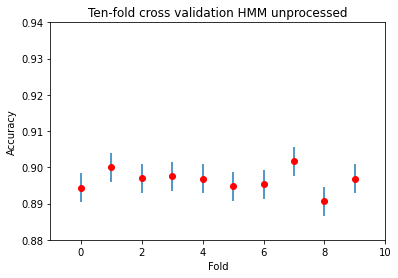

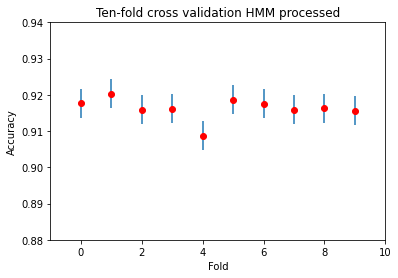

In [9]:
x=[i for i in range(10)]
y=results_hmm_unprocessed # results es una lista con los resultados de cada experimento
plt.axis([-1, 10, 0.88, 0.94])
plt.ylabel('Accuracy')
plt.xlabel('Fold')
plt.title('Ten-fold cross validation HMM unprocessed')
plt.plot(x,y,'ro')
Tic=intervals_hmm_unprocessed# Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.show()

x=[i for i in range(10)]
y=results_hmm_processed # results es una lista con los resultados de cada experimento
plt.axis([-1, 10, 0.88, 0.94])
plt.ylabel('Accuracy')
plt.xlabel('Fold')
plt.title('Ten-fold cross validation HMM processed')
plt.plot(x,y,'ro')
Tic=intervals_hmm_processed# Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.show()

// Comentamos resultados

# Tarea 2

// EXplicamos la tarea aqui

In [ ]:
%%time
results_hmm_train_limited = []
intervals_hmm_train_limited = []
for i in np.arange(0.1, 1.0, 0.1): #We iterate a list array([0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])
    #Split data
    len_training = int(i*len(processed_corpus))
    training_notcv = processed_corpus[:len_training]
    test_notcv = processed_corpus[int(0.9*len(processed_corpus)):]
    #HMM
    tagger_hmm = hmm.HiddenMarkovModelTagger.train(training_notcv)
    v = tagger_hmm.evaluate(test_notcv)
    results_hmm_train_limited.append(v)
    #Number of words on test partition
    N = 0
    for i in test_notcv: N += len(i)
    #Intervalos
    d = 1.96*math.sqrt((v*(1-v))/N)
    ic = round(d,3)
    intervals_hmm_train_limited.append(ic)
    


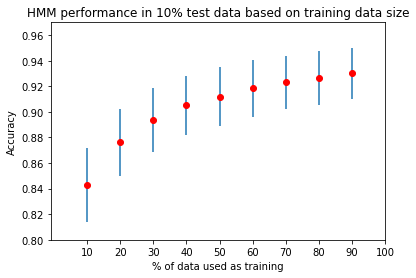

In [8]:
xticks = np.arange(10, 110, step=10)
x=xticks[:9]
y=results_hmm_train_limited # results es una lista con los resultados de cada experimento
plt.axis([-1, 10, 0.80, 0.97])
plt.xticks(xticks)
plt.ylabel('Accuracy')
plt.xlabel('% of data used as training')
plt.title('HMM performance in 10% test data based on training data size')
plt.plot(x,y,'ro')
Tic=intervals_hmm_train_limited# Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.show()

// Comentamos resultados

# Tarea 3

In [6]:
def tr_te_tnt_smooth(tr,te,n):
    # n: longitud del sufijo
    # Entrenamos y evaluamos el tagger tnt con suavizado utilizando
    # AffixTagger como etiquetador para las palabras desconocidas
    
    # Inicializamos y entrenamos AffixTagger
    sufix_tagger = AffixTagger(tr, affix_length=-n)
    # Inicializamos TnT pasando el tagger anterior como parámetro
    tnt_tagger = tnt.TnT(unk = sufix_tagger, Trained = True)
    # Entrenamos TnT
    tnt_tagger.train(tr)
    # Evaluamos con te
    return tnt_tagger.evaluate(te)

In [ ]:
%%time
from nltk import AffixTagger
results_tnt_affix_length = []
intervals_tnt_affix_length = []
for i in range(0, 10):
    #Split data
    len_training = int(0.9*len(processed_corpus))
    training_notcv = processed_corpus[:len_training]
    test_notcv = processed_corpus[len_training:]
    #Mofidy data for affix
    #TNT
    v = tr_te_tnt_smooth(training_notcv,test_notcv,i)
    results_tnt_affix_length.append(v)
    #Number of words on test partition
    N = 0
    for i in test_notcv: N += len(i)
    #Intervalos
    d = 1.96*math.sqrt((v*(1-v))/N)
    ic = round(d,3)
    intervals_tnt_affix_length.append(ic)

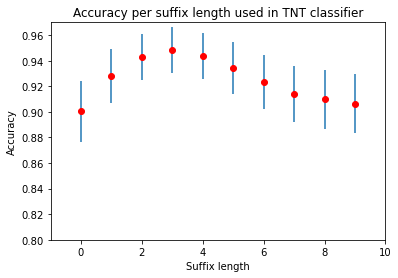

In [11]:
xticks = list(range(10))
x=xticks
y=results_tnt_affix_length # results es una lista con los resultados de cada experimento
plt.axis([-1, 10, 0.80, 0.97])
plt.ylabel('Accuracy')
plt.xlabel('Suffix length')
plt.title('Accuracy per suffix length used in TNT classifier')
plt.plot(x,y,'ro')
Tic=intervals_tnt_affix_length# Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.show()

In [16]:
%%time
# Entrenamos el Affix Tagger para distinta longitud de sufijo

from nltk.tag import AffixTagger
kf_fold = KFold(n_splits=10, shuffle=False)
results_affix_processed = [] # Global results of each 10-fold
intervals_affix_processed = [] # Global intervals of each 10-fold
for n in range(-10,0):
    tmp_results = []
    for train_index, test_index in kf_fold.split(processed_corpus):
        #Split data
        training_cv = np.take(processed_corpus,train_index).tolist()
        test_cv = np.take(processed_corpus,test_index).tolist()
        #Affix Tagger
        sufix_tagger = AffixTagger(training_cv,affix_length=-n)
        v = sufix_tagger.evaluate(test_cv)
        tmp_results.append(v)
        
    # Global result
    avg_results = sum(tmp_results)/len(tmp_results)
    results_affix_processed.append(avg_results)
    # Global interval
    tmp_global_ic = 0
    for i in range(10):
        tmp_global_ic += (tmp_results[i] - avg_results) **2
    tmp_global_ic = 1.96*math.sqrt(tmp_global_ic/len(tmp_results))
    intervals_affix_processed.append(tmp_global_ic)
    
    

CPU times: user 34.3 s, sys: 3.97 ms, total: 34.3 s
Wall time: 34.3 s


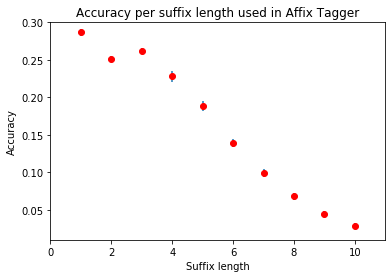

In [34]:
xticks = [-i for i in range(-10,0)]
x=xticks
y=results_affix_processed # results es una lista con los resultados de cada experimento
plt.axis([0, 11, 0.01, 0.30])
plt.ylabel('Accuracy')
plt.xlabel('Suffix length')
plt.title('Accuracy per suffix length used in Affix Tagger')
plt.plot(x,y,'ro')
Tic=intervals_affix_processed# Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.show()

#### Viendo la gráfica anterior escogemos una longitud de sufijo de 1 para entrenar tnt

In [ ]:
# Aquí se debería entrenar TNT + suavizado y TNT sin suavizado. 
# Lo dejo a medias porque tengo dudas de si se hace así.

# Train TNT+Smoothing (falta añadir TNT sin smoothing)
results_tnt_affix_length_2 = []
intervals_tnt_affix_length_2 = []
kf_fold = KFold(n_splits=10, shuffle=False)
for train_index, test_index in kf_fold.split(processed_corpus):
        #Split data
        training_cv = np.take(processed_corpus,train_index).tolist()
        test_cv = np.take(processed_corpus,test_index).tolist()
        # TNT + Smoothing
        v = tr_te_tnt_smooth(training_cv,test_cv,-1)
        results_tnt_affix_length_2.append(v)
        #Number of words on test partition
        N = 0
        for i in test_notcv: N += len(i)
        #Intervalos
        d = 1.96*math.sqrt((v*(1-v))/N)
        ic = round(d,3)
        intervals_tnt_affix_length_2.append(ic)

# Tarea 4

## Brill

In [7]:
%%time
train = processed_corpus[:int(0.9*len(corpus))]
test = processed_corpus[int(0.9*len(corpus)):]

tagger_unigramas = UnigramTagger(train)
brill.Template._cleartemplates()
templates = brill.fntbl37()
trainer = nltk.tag.brill_trainer.BrillTaggerTrainer(initial_tagger=tagger_unigramas,
                                   templates=templates, trace=3,
                                   deterministic=True)
trainer._trace=0 #We hide the training loop prints
brill_trained = trainer.train(train, max_rules=1000)

CPU times: user 51.3 s, sys: 495 ms, total: 51.8 s
Wall time: 52.3 s


In [13]:
# Brill with unigramtagger
brill_trained.evaluate(test)

0.8995891536565325

In [22]:
tagger_unigramas = hmm.HiddenMarkovModelTagger.train(train)
brill.Template._cleartemplates()
templates = brill.fntbl37()
trainer = nltk.tag.brill_trainer.BrillTaggerTrainer(initial_tagger=tagger_unigramas,
                                   templates=templates, trace=3,
                                   deterministic=True)
trainer._trace=0 #We hide the training loop prints
brill_trained = trainer.train(train, max_rules=1000)

In [23]:
# Brill with hmmtagger
brill_trained.evaluate(test)

0.9347576006573541

## CRF

In [24]:
tagger_crf = crf.CRFTagger()
tagger_crf.train(train, "model")
tagger_crf.evaluate(test)

0.9606135305395782

## Perceptron

In [25]:
tagger_perceptron = perceptron.PerceptronTagger(load = False)
tagger_perceptron.train(train)
tagger_perceptron.evaluate(test)

0.9711859764448096

In [27]:
test[0]

[('-', 'Fg'),
 ('Qué', 'pt'),
 ('podía', 'vm'),
 ('haber', 'va'),
 ('inducido', 'vm'),
 ('al', 'sp'),
 ('poeta', 'nc'),
 ('para', 'sp'),
 ('verse', 'vm'),
 ('arrastrado', 'aq'),
 ('a', 'sp'),
 ('aquel', 'dd'),
 ('descabellado', 'aq'),
 ('lance', 'nc'),
 ('?', 'Fi')]

# RNN Keras 

In [ ]:
# example of training a final classification model
from keras.models import Sequential
from keras.layers import Dense
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
# generate 2d classification dataset
X_train, y_train = make_blobs(n_samples=100, centers=2, n_features=2, random_state=1)
scalar = MinMaxScaler()
scalar.fit(X)
X = scalar.transform(X)
# define and fit the final model
model = Sequential()
model.add(Dense(4, input_dim=2, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')
model.fit(X, y, epochs=200, verbose=0)